In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import sys
import os
import json
import itertools
import umap
from colour import Color
from collections import Counter
sys.path.insert(1, "../")
sys.path.insert(1, "../utilities")

from group_analysis import do_kmeans_clustering, plot_clusters, log_and_scale, colour_list, display_group_kw_combis
from helpers import load_posts, load_toks, load_pos, get_top_n_toks
from clustering import reduce_features, make_elbow_plot, compare_binary_normed_feature_embeddings, mc_list, plot_bin_and_norm_clusters, plot_contingency_matrix, calculate_cluster_lrs

from language_change_methods.features import get_tok_counts, function_words, combine_counts, make_feature_matrix
from language_change_methods.utility_functions import basic_preprocessing, get_ngram_example, get_text_example_of_pos, make_ngram_concordance, make_pos_concordance

from sklearn.cluster import KMeans, SpectralClustering, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

from nltk import ngrams as make_ngrams

from settings import TFES_FP as DB_FP, TFES_TOK_FP
GRAPH_DIR = "./Graphs"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%%time
all_posts = load_posts(DB_FP)

from helpers import flat_earth_boards, off_topic_boards as other_boards

fe_posts = all_posts.query("board_id in @flat_earth_boards")
ot_posts = all_posts.query("board_id in @other_boards")

toks = {int(x[0]): x[1] for x in load_toks(TFES_TOK_FP)}
toks = pd.Series(toks)
toks = toks[toks.index.isin(fe_posts.index)]

pos = {int(x[0]): x[1] for x in load_pos(TFES_TOK_FP)}
pos = pd.Series(pos)
pos = pos[pos.index.isin(fe_posts.index)]
pos = pos.loc[toks.index]

fe_posts = fe_posts.loc[toks.index]

Wall time: 31 s


In [4]:
with open("../data/user_metagroup.json") as group_file:
    meta_clusts = pd.Series(json.load(group_file))
    meta_clusts.index = meta_clusts.index.astype("float64")

In [5]:
# USERS_TO_INCLUDE = "100POSTS"
USERS_TO_INCLUDE = "TOP20"

In [8]:
post_lengths = toks.apply(len)
user_n_words = post_lengths.groupby(fe_posts["poster_id"]).sum()
posts_per_user = fe_posts.groupby("poster_id").size()

over_100 = posts_per_user[posts_per_user > 100]
print(f"{len(over_100)} with > 100 posts")

top_20 = posts_per_user.sort_values(ascending=False).head(20)
print(f"{len(top_20)} in the top 20")

if USERS_TO_INCLUDE == "100POSTS":
    curr_users = over_100
elif USERS_TO_INCLUDE == "TOP20":
    curr_users = top_20
    
user_n_words = user_n_words.loc[curr_users.index]
posts_per_user = posts_per_user.loc[curr_users.index]

curr_posts = fe_posts.query("poster_id in @curr_users.index")

# Get colour gradient
colour_gradient = list(Color("red").range_to(Color("blue"),len(curr_users)))
colour_gradient = pd.Series(colour_gradient, index=curr_users.sort_values(ascending=True).index)
colour_gradient = colour_gradient.loc[curr_users.index].apply(str)

101 with > 100 posts
20 in the top 20


# Create the user text chunks

In [9]:
merge_lists = lambda x: list(itertools.chain.from_iterable(x))

def get_chunks(u, tokens, chunk_size):
    for i in range(0, len(tokens)-chunk_size, chunk_size):
        yield u, tokens[i:i+chunk_size]

In [10]:
def make_tok_chonks(tokens, chunk_size):
    user_chunks = [[[user, chunk] for user, chunk in get_chunks(user, curr_toks, chunk_size)] for user, curr_toks in tokens.items()]
    user_chunks = merge_lists(user_chunks)
    user_chunks = pd.DataFrame(user_chunks, columns=["User", "Chunk"])
    return user_chunks

In [11]:
CHUNK_SIZE = 1000

In [12]:
%%time
user_toks = toks.groupby(curr_posts["poster_id"]).apply(merge_lists)
user_chunks = make_tok_chonks(user_toks, CHUNK_SIZE)

Wall time: 304 ms


In [13]:
%%time
user_pos = pos.groupby(curr_posts["poster_id"]).apply(merge_lists)
user_pos_chunks = make_tok_chonks(user_pos, CHUNK_SIZE)

Wall time: 580 ms


# Create the Different Feature Counts

#### BOW

In [15]:
%%time
# Get the counts
bow_counts = {i: get_tok_counts(post) for i, post in user_toks.items()}
bow_counts = {i: {tok: count for tok, count in post.items() if tok not in function_words} for i, post in bow_counts.items()}
top_n = get_top_n_toks(bow_counts.values(), 10000)
bow_counts = {i: {tok: count for tok, count in post.items() if tok in top_n} for i, post in bow_counts.items()}
bow_counts = pd.Series(bow_counts)

Wall time: 13.1 s


#### Tfidf bow counts

In [16]:
%%time
# Credit for this cell: http://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/
from sklearn.feature_extraction.text import TfidfVectorizer
# If you had counts instead of tokens, you'd use "TfidfTransformer"

def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  


tfidf_matrix = tfidf.fit_transform(user_toks)

Wall time: 570 ms


In [17]:
tfidf_feats = tfidf_matrix[:, np.isin(tfidf.get_feature_names(), top_n)].todense()

#### PoS Trigrams

In [18]:
pos_trigrams = pd.Series([make_ngrams(post, 3) for post in user_pos], index=user_pos.index)
pos_trigrams = pos_trigrams.apply(lambda post: ["_".join(words) for words in post])

In [19]:
top_n = [x[0] for x in Counter(merge_lists(pos_trigrams)).most_common(1000)]
pos_tri_counts = pos_trigrams.apply(Counter).apply(lambda dic: {w: c for w, c in dic.items() if w in top_n})
pos_tri_counts = pd.Series(pos_tri_counts)

In [20]:
# pos_tri_chunks = pd.DataFrame(index=user_pos_chunks.index)
# pos_tri_chunks["User"] = user_pos_chunks["User"]
# pos_tri_chunks["Chunk"] = pos_trigrams

# Create the Feature Matrix

In [143]:
%%time
# Initialise feats to None
bin_feats = None
norm_feats = None

# Make the feature matrix
curr_feat_type = "pos_tri"
SCALE = True
APPLY_PCA = True

if curr_feat_type == "pos_tri":
    curr_counts = pos_tri_counts
    curr_toks = pos_trigrams
elif curr_feat_type == "bow":
    curr_counts = bow_counts
    curr_toks = user_toks
elif curr_feat_type == "tfidf":
    curr_counts = bow_counts
    curr_toks = user_toks
    bin_feats = np.vectorize(lambda x: 1 if x > 0 else 0)(tfidf_feats)
    norm_feats = tfidf_feats
    
if bin_feats is None:
    curr_feats, curr_feat_names = make_feature_matrix(curr_counts.to_dict(), False)
    bin_feats = np.vectorize(lambda x: 1 if x > 0 else 0)(curr_feats)
    norm_feats = curr_feats / user_toks.apply(len).values[:,None]

Wall time: 98.5 ms


#### Scaling

In [144]:
if SCALE:
    norm_feats = StandardScaler().fit_transform(norm_feats)

#### PCA reduction

In [145]:
%%time
from sklearn.decomposition import PCA
pca = PCA(.95)

if APPLY_PCA:
    norm_feats = pca.fit_transform(norm_feats)

Wall time: 12.5 ms


In [146]:
print(f"{norm_feats.shape[1]} components")

18 components


#### Make 2d embeddings

In [147]:
%%time
norm_embedding = reduce_features(norm_feats)

Wall time: 571 ms


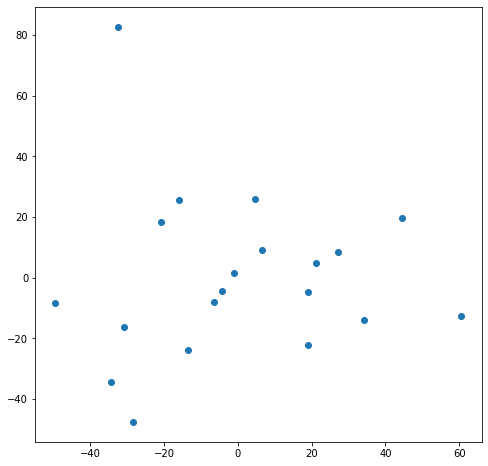

In [148]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(norm_feats[:,0], norm_feats[:,1])
plt.show()

# Do the Clustering

In [149]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cosine as cosine_dist
from sklearn.cluster import AgglomerativeClustering

In [150]:
def plot_hc(feats, labels, out_fp=None):
    # Perform the Hierarchical Clustering
    d_list = linkage(feats, 'average', metric="cosine")

    # Calculate the Cophenetic Correlation Coefficient
    c, coph_dists = cophenet(d_list, pdist(feats))
    print("Cophenetic Correlation Coefficient: {}".format(c))

    # Do the actual plotting.
    fig, ax = plt.subplots(figsize=(12,3))
    
    dendrogram(
        d_list,
        leaf_rotation=0,  # rotates the x axis labels
        leaf_font_size=14,  # font size for the x axis labels
        labels = labels, 
        ax=ax,
        color_threshold=0
    )
    plt.setp(ax.get_xticklabels(), fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.set_xlabel("Users", fontsize=14)
    ax.set_ylabel("Cosine Distance", fontsize=14)
    ax.grid()
    
    plt.tight_layout()
    if out_fp is not None:
        fig.savefig(out_fp)

Cophenetic Correlation Coefficient: 0.4378522054564876


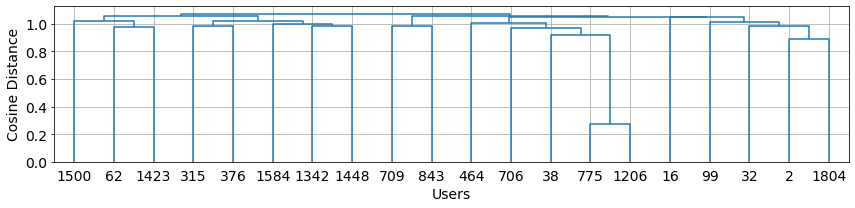

In [151]:
plot_hc(norm_feats, user_toks.index.astype(int), out_fp=os.path.join(GRAPH_DIR, f"dendrogram_{curr_feat_type}.pdf"))

In [152]:
%%time
for i in range(2,10):
    model = AgglomerativeClustering(n_clusters=i, affinity='cosine', linkage='average')  
    clusters = model.fit_predict(norm_feats)
    avg_silhouette_score = metrics.silhouette_score(norm_feats, clusters)
    print(f"Average silhoette score for {i} clusters:\t", avg_silhouette_score, "\n")

Average silhoette score for 2 clusters:	 0.024270137946065706 

Average silhoette score for 3 clusters:	 0.019024709161948195 

Average silhoette score for 4 clusters:	 0.017206603833015064 

Average silhoette score for 5 clusters:	 -0.02686079473739474 

Average silhoette score for 6 clusters:	 -0.019422768929847425 

Average silhoette score for 7 clusters:	 -0.020319881084234954 

Average silhoette score for 8 clusters:	 -0.015681306937310485 

Average silhoette score for 9 clusters:	 -0.010559412465715904 

Wall time: 10.5 ms


In [153]:
model = AgglomerativeClustering(n_clusters=2, affinity='cosine', linkage='average')  
clusters = model.fit_predict(norm_feats)

In [154]:
model = AgglomerativeClustering(n_clusters=None, distance_threshold=1, affinity='cosine', linkage='average')  
clusters2 = model.fit_predict(norm_feats)

In [155]:
avg_silhouette_score = metrics.silhouette_score(norm_feats, clusters)
print("Average silhoette score for Normed:\t", avg_silhouette_score, "\n")

Average silhoette score for Normed:	 0.024270137946065706 



In [156]:
for clust in set(clusters):
    print(clust, list(user_toks[clusters==clust].index))

0 [2.0, 16.0, 32.0, 38.0, 99.0, 464.0, 706.0, 709.0, 775.0, 843.0, 1206.0, 1804.0]
1 [62.0, 315.0, 376.0, 1342.0, 1423.0, 1448.0, 1500.0, 1584.0]


In [157]:
print(",".join(map(str, user_toks.index)))
print(",".join(map(str, clusters)))

2.0,16.0,32.0,38.0,62.0,99.0,315.0,376.0,464.0,706.0,709.0,775.0,843.0,1206.0,1342.0,1423.0,1448.0,1500.0,1584.0,1804.0
0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,1,1,1,1,0


In [158]:
for i, (c1, c2) in enumerate(zip(clusters, clusters2)):
    print(i, c1, c2, sep=",")

0,0,1
1,0,5
2,0,1
3,0,3
4,1,4
5,0,8
6,1,6
7,1,6
8,0,9
9,0,3
10,0,2
11,0,3
12,0,2
13,0,3
14,1,0
15,1,4
16,1,0
17,1,7
18,1,0
19,0,1


In [159]:
ling_clusts = {"Cluster 0": list(user_toks[clusters==0].index), 
               "Cluster 1": list(user_toks[clusters==1].index)}

with open(os.path.join(GRAPH_DIR, "ling_clusts.json"), "w") as out_file:
    json.dump(ling_clusts, out_file)

In [160]:
# # This was me just checking that SKLearn produced the same clusters as SciPy.
# from scipy.cluster.hierarchy import fclusterdata
# clusters = fclusterdata(norm_feats, t=2, criterion="maxclust", metric="cosine", method="average")
# # clusters = fclusterdata(norm_feats, t=1, criterion="distance", metric="cosine", method="average")

# clusters = clusters - 1
# for clust in set(clusters):
#     print(clust, list(user_toks[clusters==clust].index))

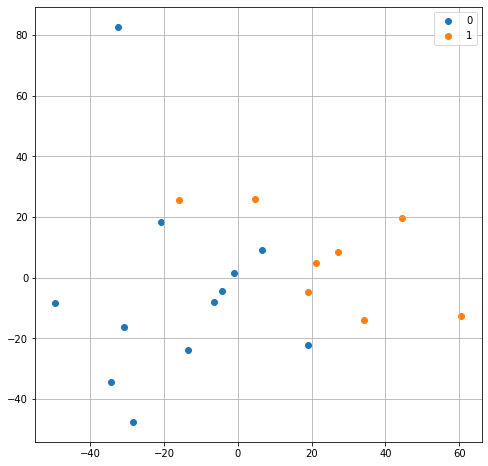

In [161]:
fig, ax = plt.subplots(figsize=(8,8))
for c in set(clusters):
    ax.scatter(norm_feats[clusters==c,0], norm_feats[clusters==c,1], label=c)
ax.grid()
ax.legend()
plt.show()

# Analyse Spread Across Users

In [162]:
user_toks.index[clusters==0]

Float64Index([2.0, 16.0, 32.0, 38.0, 99.0, 464.0, 706.0, 709.0, 775.0, 843.0,
              1206.0, 1804.0],
             dtype='float64', name='poster_id')

In [163]:
user_toks.index[clusters==1]

Float64Index([62.0, 315.0, 376.0, 1342.0, 1423.0, 1448.0, 1500.0, 1584.0], dtype='float64', name='poster_id')

In [164]:
contingency = pd.crosstab(user_toks.index.values, [clusters], rownames=["User"], colnames=["Cluster"])

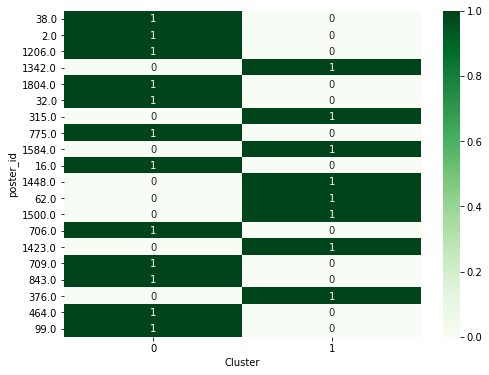

In [165]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(contingency.loc[top_20.index], annot=True, ax=ax, fmt='g', cmap="Greens")
# fig.savefig(os.path.join(GRAPH_DIR, f"chunk_contingency_2_{curr_feat_type}.pdf"))
plt.show()

In [166]:
for clust in set(clusters):
    print(clust, list(user_toks[clusters==clust].index))

0 [2.0, 16.0, 32.0, 38.0, 99.0, 464.0, 706.0, 709.0, 775.0, 843.0, 1206.0, 1804.0]
1 [62.0, 315.0, 376.0, 1342.0, 1423.0, 1448.0, 1500.0, 1584.0]


In [167]:
contingency.idxmax(axis=1)

User
2.0       0
16.0      0
32.0      0
38.0      0
62.0      1
99.0      0
315.0     1
376.0     1
464.0     0
706.0     0
709.0     0
775.0     0
843.0     0
1206.0    0
1342.0    1
1423.0    1
1448.0    1
1500.0    1
1584.0    1
1804.0    0
dtype: int64

In [168]:
posts_per_user.loc[user_toks[clusters==0].index].mean()

1670.1666666666667

In [169]:
posts_per_user.loc[user_toks[clusters==1].index].mean()

1110.0

In [170]:
user_toks.apply(len)[clusters==0].mean()

159255.41666666666

In [171]:
user_toks.apply(len)[clusters==1].mean()

128117.625

In [172]:
FE_belief = {38: 'FE', 
             2: 'FE', 
             1206: 'RE', 
             1342: 'RE', 
             1804: 'FE', 
             32: 'UNK', 
             315: 'RE', 
             775: 'RE', 
             1584: 'RE', 
             16: 'RE', 
             1448: 'RE', 
             62: 'RE', 
             1500: 'UNK', 
             706: 'RE', 
             1423: 'FE', 
             709: 'RE', 
             843: 'RE', 
             376: 'RE', 
             464: 'RE', 
             99: 'RE'}

FE_belief = pd.Series(FE_belief)
FE_belief = FE_belief.loc[user_toks.index]

In [173]:
FE_belief

poster_id
2.0        FE
16.0       RE
32.0      UNK
38.0       FE
62.0       RE
99.0       RE
315.0      RE
376.0      RE
464.0      RE
706.0      RE
709.0      RE
775.0      RE
843.0      RE
1206.0     RE
1342.0     RE
1423.0     FE
1448.0     RE
1500.0    UNK
1584.0     RE
1804.0     FE
dtype: object

In [174]:
FE_belief[clusters==0]

poster_id
2.0        FE
16.0       RE
32.0      UNK
38.0       FE
99.0       RE
464.0      RE
706.0      RE
709.0      RE
775.0      RE
843.0      RE
1206.0     RE
1804.0     FE
dtype: object

In [175]:
FE_belief[clusters==1]

poster_id
62.0       RE
315.0      RE
376.0      RE
1342.0     RE
1423.0     FE
1448.0     RE
1500.0    UNK
1584.0     RE
dtype: object

#### Making little table showing clusters and belief

In [176]:
contingency = pd.crosstab(user_toks.index.values, [clusters], rownames=["User"], colnames=["Cluster"])

In [177]:
clusters

array([0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0],
      dtype=int64)

In [178]:
clusters2

array([1, 5, 1, 3, 4, 8, 6, 6, 9, 3, 2, 3, 2, 3, 0, 4, 0, 7, 0, 1],
      dtype=int64)

In [179]:
clust_belief_table = pd.DataFrame(index=user_toks.index)
clust_belief_table["Cluster"] = clusters
clust_belief_table["Cluster 2"] = clusters2
clust_belief_table["Belief"] = FE_belief.loc[clust_belief_table.index]

In [180]:
clust_belief_table.sort_values("Cluster")

,Cluster,Cluster 2,Belief
poster_id,,,
2.0,0,1,FE
1206.0,0,3,RE
843.0,0,2,RE
775.0,0,3,RE
709.0,0,2,RE
464.0,0,9,RE
706.0,0,3,RE
99.0,0,8,RE
38.0,0,3,FE


In [181]:
clust_belief_table.sort_values("Cluster 2")

,Cluster,Cluster 2,Belief
poster_id,,,
1448.0,1,0,RE
1342.0,1,0,RE
1584.0,1,0,RE
2.0,0,1,FE
1804.0,0,1,FE
32.0,0,1,UNK
709.0,0,2,RE
843.0,0,2,RE
38.0,0,3,FE


# Get Some Keywords Between Clusters

In [72]:
%%time
lr = lambda x, y: np.log2(x / y)

def get_cluster_keywords(tokens, clusters):
    
    clust_counts = tokens.groupby(clusters).apply(
                    lambda x: [Counter(merge_lists(x))]).apply(
                    lambda x: x[0])
    clust_n_words = {clust: tokens[clusters==clust].apply(len).sum() for clust in set(clusters)}

    for clust, counts in clust_counts.items():
        other_counts = Counter(merge_lists(tokens[clusters!=clust]))
        other_nwords = tokens[clusters!=clust].apply(len).sum()
        lrs = calculate_cluster_lrs(counts, other_counts, clust_n_words[clust], other_nwords)
        lrs = {w: l for w, l in lrs.items() if counts[w] > 100}
        lrs = pd.Series(lrs).sort_values(ascending=False)
        t10_lr = lrs.head(20)
        b10_lr = lrs.tail(20)

        print(clust)
        print("-------------------------------------------------------------------------------------")
        for (w1, lr1), (w2, lr2) in zip(t10_lr.items(), b10_lr.items()):
            print(f"{w1:20}\t{lr1:10.2f}\t|\t{w2:20}\t{lr2:10.2f}")
        print("-------------------------------------------------------------------------------------")

Wall time: 0 ns


In [73]:
def get_cluster_lrs(tokens, clusters, min_freq=100):
    
    clust_counts = tokens.groupby(clusters).apply(
                    lambda x: [Counter(merge_lists(x))]).apply(
                    lambda x: x[0])
    clust_n_words = {clust: tokens[clusters==clust].apply(len).sum() for clust in set(clusters)}
    
    clust_kw = dict()

    for clust, counts in clust_counts.items():
        other_counts = Counter(merge_lists(tokens[clusters!=clust]))
        other_nwords = tokens[clusters!=clust].apply(len).sum()
        lrs = calculate_cluster_lrs(counts, other_counts, clust_n_words[clust], other_nwords)
        lrs = {w: l for w, l in lrs.items() if counts[w] > min_freq}
        lrs = pd.Series(lrs).sort_values(ascending=False)
   
        clust_kw[clust] = lrs
    return clust_kw

In [74]:
%%time
get_cluster_keywords(pos_trigrams, clusters)

0
-------------------------------------------------------------------------------------
PUNCT_INTJ_INTJ     	      1.90	|	ADV_DET_PROPN       	     -1.37
ADV_INTJ_PUNCT      	      1.82	|	PROPN_PUNCT_ADP     	     -1.37
INTJ_INTJ_PUNCT     	      1.80	|	ADP_PUNCT_PROPN     	     -1.40
ADJ_ADV_PRON        	      1.71	|	PROPN_NOUN_NOUN     	     -1.43
CCONJ_INTJ_PUNCT    	      1.69	|	PROPN_PROPN_PROPN   	     -1.46
PART_ADJ_ADV        	      1.65	|	PROPN_PUNCT_PUNCT   	     -1.47
PART_ADJ_PRON       	      1.62	|	PUNCT_ADP_PROPN     	     -1.47
INTJ_VERB_ADP       	      1.51	|	PUNCT_PUNCT_PUNCT   	     -1.49
INTJ_PUNCT_ADJ      	      1.51	|	NUM_SYM_NUM         	     -1.49
AUX_ADJ_PRON        	      1.46	|	PROPN_PROPN_CCONJ   	     -1.51
PUNCT_CCONJ_INTJ    	      1.42	|	DET_PROPN_PROPN     	     -1.52
ADV_CCONJ_PRON      	      1.42	|	SYM_NUM_NOUN        	     -1.58
SCONJ_VERB_PRON     	      1.29	|	ADP_ADV_NUM         	     -1.60
INTJ_PUNCT_VERB     	      1.29	|	PROPN_PUNCT_PROPN   

In [75]:
get_text_example_of_pos(["PUNCT", "INTJ", "INTJ"], 
                        user_pos[clusters==0], 
                        user_toks[clusters==0], 
                        doc_labels=user_toks[clusters==0].index, n_examples=25)

Showing 25 out of 143:
2.0        ouncilors have voting privileges now . uh oh , fixed . gah. fixed . well , that w
2.0         i . live up to your own standards . hell yeah . or we could use lulu , like tint
2.0        possible is considerably harder than " oh no , it takes effort " all us dollars a
2.0        ave breasts . my chest is very flat . hi fogo4 , thanks for stopping by . this cla
2.0        inal claim from the very same page ) : oh my . you did n't think it magically tra
2.0        , and then you 'd probably say that " oh well , they were pretty close to speakin
2.0        warning to this effect will follow . hi hoopera , thanks for stopping by . i hope 
2.0        ermines what i said or did n't say ? gosh darn it , why was n't i informed !? i a
2.0        now , falsity implies all statements . oh my . perhaps you should n't have used t
2.0         piece of very anecdotal evidence . hi sandokhan , i will repeat this to you once 
2.0         tried denying that your position

In [76]:
get_text_example_of_pos(["ADJ", "ADV", "PRON"], 
                        user_pos[clusters==0], 
                        user_toks[clusters==0], 
                        doc_labels=user_toks[clusters==0].index, n_examples=25)

Showing 25 out of 386:
2.0         to push your own name . i 'm not sure how that 's an explicit declaration of lac
2.0        es , because that 's definitely relevant when one 's explicitly calculating magni
2.0         , assumptions . almost . i 'm not sure why you 'd restrict yourself to just the s
2.0        nce between two objects , that 's likely why you never heard such a claim being ma
2.0        e ol link again . it was n't good enough when it was just markjo posting it . i re
2.0        tic , but you 're virtually never right when it comes to the subtleties of englis
2.0         a reaction . that said , i 'm not sure why you consider yourself an authority on 
2.0        s to the bag. 700 * , but i 'm not sure why you think your perception of the sever
2.0        y these days . i almost liked you more when you actually tried . almost . thork ,
2.0        ce in vauxy 's scenario . i 'm not sure why you 'd expect anything else . i can on
2.0        e rules as before apply . i 'm

In [77]:
get_text_example_of_pos(["NUM", "PROPN", "NUM"], 
                        user_pos[clusters==1], 
                        user_toks[clusters==1], 
                        doc_labels=user_toks[clusters==1].index, n_examples=25)

Showing 25 out of 129:
38.0       tic society the zetetic vol1 , no. 1 july 1872 does the earth rotate by william e
38.0       ation is found in corinthians : 1 corinthians 3:11 : " for no man can lay a founda
38.0       to die . king david also says it in 1 kings 2 : i do find it interesting that a g
38.0       tructions to moses from exodus 27:17 genesis 28:18 exodus 34:13 judges 16:25 judg
38.0       moses from exodus 27:17 genesis 28:18 exodus 34:13 judges 16:25 judges 16:26 1 kin
38.0       us 34:13 judges 16:25 judges 16:26 1 kings 7:2 manâs pillars are solid and sta
38.0       tatic . godâs pillars exodus 13:21 exodus 14:24 exodus 14:19 exodus 33:9 number
38.0       s pillars exodus 13:21 exodus 14:24 exodus 14:19 exodus 33:9 numbers 12:5 we can
38.0       xodus 13:21 exodus 14:24 exodus 14:19 exodus 33:9 numbers 12:5 we can see the nat
38.0       e earth are on pillars : job 26:11 1 samuel 2:8 now , would god be using manâs 
38.0       what it may mean : romans 14:4 

In [78]:
%%time
concs = make_pos_concordance(["NUM", "PROPN", "NUM"],
                             user_pos[clusters==1],
                             user_toks[clusters==1],
                             doc_labels=user_toks[clusters==1].index)
concs = pd.DataFrame(concs, columns=["user", "conc"])

print("Distribution across users:")
num_uses_per_user = concs.groupby("user").size()
print("Num uses per user", num_uses_per_user, sep="\n", end="\n\n")
print("Mean uses per user:\t", num_uses_per_user.mean())
print("Median uses per user:\t", num_uses_per_user.median())

Distribution across users:
Num uses per user
user
38.0      11
99.0       3
315.0     71
376.0      1
1342.0    20
1448.0     4
1500.0     8
1584.0    11
dtype: int64

Mean uses per user:	 16.125
Median uses per user:	 9.5
Wall time: 1.85 s


In [79]:
%%time
get_text_example_of_pos(["PROPN", "ADV", "DET"], 
                        user_pos[clusters==1], 
                        user_toks[clusters==1], 
                        doc_labels=user_toks[clusters==1].index, n_examples=25)

Showing 25 out of 417:
16.0       eminent samuel birley rowbotham of earth not a globe fame ) believe that the moon
16.0        is currently off the shore of antarctica where the magnetic field lines are verti
38.0       ricism . read the first chapter of earth not a globe for a primer . admittedly , 
38.0       pter to a new annotated edition of earth not a globe . when the chapter is done w
38.0        2 . write an annotated edition of earth not a globe 3 . improve the wiki 4 . org
38.0       ojects in the works , an annotated earth not a globe , an encyclopedia wiki , a v
38.0       the earth , and i 've seen math in earth not a globe to compute convexity . math 
38.0       the all the stars went around the earth then the gravitational pull of the stars w
38.0       red or blue . this is addressed in earth not a globe and the last pdf i posted ab
38.0       . his work can be read in the book earth not a globe , which can be found for fre
38.0       be included in a modern edition of

In [80]:
%%time
c = 1
concs = make_pos_concordance(["PROPN", "ADV", "DET"],
                             user_pos[clusters==c],
                             user_toks[clusters==c],
                             doc_labels=user_toks[clusters==c].index)
concs = pd.DataFrame(concs, columns=["user", "conc"])

print("Distribution across users:")
num_uses_per_user = concs.groupby("user").size()
print("Num uses per user", num_uses_per_user, sep="\n", end="\n\n")
print("Mean uses per user:\t", num_uses_per_user.mean())
print("Median uses per user:\t", num_uses_per_user.median())

Distribution across users:
Num uses per user
user
16.0        2
38.0      306
99.0        8
315.0      20
376.0      17
706.0      12
1342.0      3
1423.0      3
1448.0     26
1500.0     10
1584.0     10
dtype: int64

Mean uses per user:	 37.90909090909091
Median uses per user:	 10.0
Wall time: 12.2 s


In [81]:
%%time
get_text_example_of_pos(["NUM", "NOUN", "PROPN"], 
                        user_pos[clusters==1], 
                        user_toks[clusters==1], 
                        doc_labels=user_toks[clusters==1].index, n_examples=25)

Showing 25 out of 316:
38.0        . the same way someone can put a 6 cylinder bmw engine in the chassis of a honda 
38.0       found on the internet , which has 0 degrees east as the center point . no such lay
38.0       hit america from europe . the top two stages a9 and a10 can be used as a stand al
38.0       at we should go for the $ 4 million dollar antarctica trip , but that it might be
38.0       iently forgotten that for over 300 years california was depicted in maps as an isl
38.0       for example , for over three hundred years california was depicted as an island of
38.0       . how would we know ? for over 300 years california was depicted in maps as an isl
38.0       very 4 years . sidreal day = 23.933333 hours sidreal year = 365.25636 days 365.25
38.0       y looking at the numbers that the 24 hour solar day wo n't fit into a 365.24 day 
38.0       that . the closest kind of year a 24 hour solar day could fit into is if the eart
38.0       e place in the sky at that poin

In [82]:
%%time
c = 1
concs = make_pos_concordance(["NUM", "NOUN", "PROPN"],
                             user_pos[clusters==c],
                             user_toks[clusters==c],
                             doc_labels=user_toks[clusters==c].index)
concs = pd.DataFrame(concs, columns=["user", "conc"])

print("Distribution across users:")
num_uses_per_user = concs.groupby("user").size()
print("Num uses per user", num_uses_per_user, sep="\n", end="\n\n")
print("Mean uses per user:\t", num_uses_per_user.mean())
print("Median uses per user:\t", num_uses_per_user.median())

Distribution across users:
Num uses per user
user
38.0       62
99.0        9
315.0     175
376.0       6
706.0       8
1342.0     22
1423.0      5
1448.0     11
1500.0      9
1584.0      9
dtype: int64

Mean uses per user:	 31.6
Median uses per user:	 9.0
Wall time: 5.1 s


In [83]:
%%time
get_cluster_keywords(user_toks, clusters)

0
-------------------------------------------------------------------------------------
fora                	      6.88	|	per                 	     -1.29
warned              	      5.90	|	south               	     -1.36
refrain             	      4.93	|	flight              	     -1.37
warning             	      4.36	|	ship                	     -1.40
basics              	      3.25	|	map                 	     -1.45
moved               	      2.79	|	full                	     -1.45
faq                 	      2.78	|	maps                	     -1.46
silly               	      2.53	|	near                	     -1.46
fes                 	      2.50	|	lunar               	     -1.53
welcome             	      2.47	|	bodies              	     -1.54
love                	      2.39	|	solar               	     -1.68
posting             	      2.37	|	north               	     -1.69
nonsense            	      2.36	|	west                	     -1.71
acting              	      2.33	|	equator             

In [84]:
%%time
clust_lrs = get_cluster_lrs(user_toks, clusters)

Wall time: 1.03 s


In [85]:
(clust_lrs[0]["re'ers"])

1.4198131562924783

In [86]:
clust_lrs[1]["fe'ers"]

1.1193471595045326

In [87]:
clust_lrs[1]["flat"]

0.4700308347725404

In [88]:
clust_lrs[1]["round"]

0.29152398017385284

In [89]:
c1 = len(make_ngram_concordance(["flat", "earthers"],
                                user_toks[clusters==0],
                                doc_labels=user_toks[clusters==0].index))

c2 = len(make_ngram_concordance(["flat", "earthers"],
                                user_toks[clusters==1],
                                doc_labels=user_toks[clusters==1].index))

n1 = user_toks[clusters==0].apply(len).sum()
n2 = user_toks[clusters==1].apply(len).sum()

print(f"Cluster 0: {c1} / {n1}")
print(f"Cluster 1: {c2} / {n2}")
lr((c1+0.5)/n1, (c2+0.5)/n2)

Cluster 0: 121 / 1053288
Cluster 1: 231 / 1882718


-0.09213892103535011

In [90]:
c1 = len(make_ngram_concordance(["round", "earthers"],
                                user_toks[clusters==0],
                                doc_labels=user_toks[clusters==0].index))

c2 = len(make_ngram_concordance(["round", "earthers"],
                                user_toks[clusters==1],
                                doc_labels=user_toks[clusters==1].index))

n1 = user_toks[clusters==0].apply(len).sum()
n2 = user_toks[clusters==1].apply(len).sum()

print(f"Cluster 0: {c1} / {n1}")
print(f"Cluster 1: {c2} / {n2}")
lr((c1+0.5)/n1, (c2+0.5)/n2)

Cluster 0: 65 / 1053288
Cluster 1: 47 / 1882718


1.3014843518256078

In [91]:
get_ngram_example(["fe'ers"],
                  user_toks[clusters==0],
                  doc_labels=user_toks[clusters==0].index, n_examples=25)

Showing 25 out of 98:
2.0        ts in which " theory " may be used by fe'ers . within the context of " conspiracy 
2.0        s used in exactly the same fashion by fe'ers as other scientists , by way of provi
2.0        y be correct if he simply spoke to no fe'ers at all . personally , i propose that 
2.0        t large . that is not a claim serious fe'ers would make , in my humble opinion . p
2.0        ct and following the more influential fe'ers online . in other words : yes , but y
2.0        hat the most - supported map is among fe'ers . could you just go away now ? how do
2.0        uld be silly . rowbotham 's and other fe'ers ' experiments are reproducible . rabi
2.0        ised for some of the more belligerent fe'ers which appeared to target him at the t
2.0        ace in the few . yes , there are some fe'ers who are working on alternative models
2.0        olly , we sure showed those gosh darn fe'ers ! " engaging with them is an utter wa
2.0        gestions have garnered crit

In [92]:
%%time
concs = make_ngram_concordance(["fe'ers"],
                               user_toks[clusters==0],
                               doc_labels=user_toks[clusters==0].index)
concs = pd.DataFrame(concs, columns=["user", "conc"])


print("Distribution across users:")
num_uses_per_user = concs.groupby("user").size()
print("Num uses per user", num_uses_per_user, sep="\n", end="\n\n")
print("Mean uses per user:\t", num_uses_per_user.mean())
print("Median uses per user:\t", num_uses_per_user.median())

Distribution across users:
Num uses per user
user
2.0      84
709.0    10
775.0     4
dtype: int64

Mean uses per user:	 32.666666666666664
Median uses per user:	 10.0
Wall time: 1.41 s


In [93]:
get_ngram_example(["fe'ers"],
                  user_toks[clusters==1],
                  doc_labels=user_toks[clusters==1].index, n_examples=25)

Showing 25 out of 382:
16.0       ew earth , or one of the other fringe fe'ers . why ? we already have flat earth in
16.0       at , because that is an argument that fe'ers would lose . how 's this ? aether win
16.0       t will ever happen . unless and until fe'ers can start supporting their fe " model
16.0        than fes grade school . tom , to say fe'ers " often " try to provide supporting m
16.0       at i 've seen over the past 7 years , fe'ers tend to be deathly afraid of math . a
16.0       gulation . what i 'm talking about is fe'ers providing maths showing that fet does
16.0       ted to show why fet does n't work but fe'ers are n't obligated show why fet does w
16.0       s enough to empirically convince most fe'ers that the earth is flat . you take oth
16.0       ll see for yourself . actually , some fe'ers ( including the eminent samuel birley
16.0       just goes to show what slimy assholes fe'ers can be when they 're proven wrong . n
16.0        flat stationary earth . i

In [94]:
%%time
concs = make_ngram_concordance(["fe'ers"],
                               user_toks[clusters==1],
                               doc_labels=user_toks[clusters==1].index)
concs = pd.DataFrame(concs, columns=["user", "conc"])


print("Distribution across users:")
num_uses_per_user = concs.groupby("user").size()
print("Num uses per user", num_uses_per_user, sep="\n", end="\n\n")
print("Mean uses per user:\t", num_uses_per_user.mean())
print("Median uses per user:\t", num_uses_per_user.median())

Distribution across users:
Num uses per user
user
16.0       39
38.0       19
706.0     323
1342.0      1
dtype: int64

Mean uses per user:	 95.5
Median uses per user:	 29.0
Wall time: 5.1 s


In [95]:
get_ngram_example(["re'ers"],
                  user_toks[clusters==0],
                  doc_labels=user_toks[clusters==0].index, n_examples=25)

Showing 25 out of 117:
2.0        ! code : [ select ] to know that some re'ers do n't understand grade school physic
2.0        ers together with " to know that some re'ers do n't understand grade school physic
2.0         " , so i 'm not holding that against re'ers in general , but it does go a long wa
2.0         " unknown " and " untrue " ? because re'ers sure like to conflate the two when it
2.0        ld favourite of mine was to challenge re'ers to demonstrate that bananas attract e
2.0        ng bored with flogging a dead horse ( re'ers refusing to acknowledge our points an
2.0        forum . it 's just a circle - jerk of re'ers talking about how smart they think th
2.0        sadly you failed . since according to re'ers the cavendish experiment clearly work
2.0        u still here ? i have no problem with re'ers . i have a problem with people who co
2.0        very point of scepticism . unlike the re'ers who visit here to act all high and mi
2.0        oint ? no one makes that a

In [96]:
%%time
concs = make_ngram_concordance(["re'ers"],
                               user_toks[clusters==0],
                               doc_labels=user_toks[clusters==0].index)
concs = pd.DataFrame(concs, columns=["user", "conc"])


print("Distribution across users:")
num_uses_per_user = concs.groupby("user").size()
print("Num uses per user", num_uses_per_user, sep="\n", end="\n\n")
print("Mean uses per user:\t", num_uses_per_user.mean())
print("Median uses per user:\t", num_uses_per_user.median())

Distribution across users:
Num uses per user
user
2.0      115
709.0      2
dtype: int64

Mean uses per user:	 58.5
Median uses per user:	 58.5
Wall time: 2.2 s


In [97]:
get_ngram_example(["re'ers"],
                  user_toks[clusters==1],
                  doc_labels=user_toks[clusters==1].index, n_examples=25)

Showing 25 out of 78:
16.0       at you mention , the math was done by re'ers to show the improbability of the vari
16.0       aths showing that fet does work , not re'ers providing maths showing that fet does
16.0       ng to do with timing . why is it that re'ers are obligated to show why fet does n'
16.0       pp , you know that us poor , ignorant re'ers need to be spoon fed everything . tom
16.0        i 'm serious . there are a few of is re'ers ( well , me for one ) who would actua
16.0       and he has little use or patience for re'ers . if you 're an re'er , do n't even d
16.0        do n't think that very many people ( re'ers and fe'ers alike ) realize how much o
16.0       to answer a question that has plagued re'ers for many years : what evidence do re'
16.0       ers for many years : what evidence do re'ers need provide in order to satisfy thei
16.0       re seeing exactly the same thing that re'ers are seeing and the important parts of
16.0       rea where they can discuss 

In [98]:
get_ngram_example(["flat", "earthers"],
                  user_toks[clusters==0],
                  doc_labels=user_toks[clusters==0].index, n_examples=25)

Showing 25 out of 121:
2.0        er well . unfortunately , not all flat earthers are zeteticists , and we do have 
2.0         comments from round earthers and flat earthers alike , i would like to ask every
2.0         answering questions on behalf of flat earthers , especially if you 're going to 
2.0        . a bunch of the things you say " flat earthers " claim simply do not apply to th
2.0        ng something along the lines of " flat earthers claim that 2+2=5 and that is wron
2.0        ere , welcome to the forum . most flat earthers are primarily concerned with the 
2.0        nestly do n't think there are any flat earthers here who would claim california a
2.0        up a relatively small minority of flat earthers , very far from your alleged " al
2.0        way to carry on doing his thing . flat earthers ( or fe'ers for short ) is the mo
2.0        adbible ( click ) 21/08/2017 what flat earthers are saying about the total solar 
2.0         global news ( click ) 30/10/2017 fl

In [99]:
%%time
concs = make_ngram_concordance(["flat", "earthers"],
                               user_toks[clusters==0],
                               doc_labels=user_toks[clusters==0].index)
concs = pd.DataFrame(concs, columns=["user", "conc"])

print("Distribution across users:")
num_uses_per_user = concs.groupby("user").size()
print("Num uses per user", num_uses_per_user, sep="\n", end="\n\n")
print("Mean uses per user:\t", num_uses_per_user.mean())
print("Median uses per user:\t", num_uses_per_user.median())

Distribution across users:
Num uses per user
user
2.0       31
464.0     33
709.0      4
843.0     10
1206.0    42
1804.0     1
dtype: int64

Mean uses per user:	 20.166666666666668
Median uses per user:	 20.5
Wall time: 1.65 s


In [100]:
get_ngram_example(["flat", "earthers"],
                  user_toks[clusters==1],
                  doc_labels=user_toks[clusters==1].index, n_examples=25)

Showing 25 out of 231:
16.0       stances to be the same ? not even flat earthers ? then please do so . it would be
38.0       e projects , and speak with other flat earthers . news releases should be in hold
38.0        it had n't been discovered yet . flat earthers corrected the model in the early 
38.0        to , say , ask a question to the flat earthers . if we had a dollar for every qu
38.0       ky . the ancient babylonians were flat earthers . flat earth theory is better . t
38.0       ians and ancient babylonians were flat earthers as a society . it is worth noting
38.0       nt ? the ancient babylonians were flat earthers and they could predict cosmic eve
38.0       saros cycle , a method created by flat earthers . pathetic . how does that experi
38.0       is an informational query for any flat earthers on this forum . let s say that i 
38.0        talked to shaq they would become flat earthers too . shaq is a doctor which stud
38.0       nasa is using a method created by fl

In [101]:
%%time
concs = make_ngram_concordance(["flat", "earthers"],
                               user_toks[clusters==1],
                               doc_labels=user_toks[clusters==1].index)
concs = pd.DataFrame(concs, columns=["user", "conc"])

print("Distribution across users:")
num_uses_per_user = concs.groupby("user").size()
print("Num uses per user", num_uses_per_user, sep="\n", end="\n\n")
print("Mean uses per user:\t", num_uses_per_user.mean())
print("Median uses per user:\t", num_uses_per_user.median())

Distribution across users:
Num uses per user
user
16.0        1
38.0       30
315.0     112
376.0      12
706.0      36
1342.0      2
1423.0     19
1448.0      8
1500.0      8
1584.0      3
dtype: int64

Mean uses per user:	 23.1
Median uses per user:	 10.0
Wall time: 3.56 s


In [102]:
get_ngram_example(["round", "earthers"],
                  user_toks[clusters==0],
                  doc_labels=user_toks[clusters==0].index, n_examples=25)

Showing 25 out of 65:
2.0        l be helpful here : ( attention , round earthers : not to scale ) the mass of the 
2.0        r views . even the most laughable round earthers at least make an effort . you , o
2.0         round earth is much smaller than round earthers would have you believe . where cu
2.0        internet and are well accepted by round earthers . a quick google search to the ef
2.0        y our village idiot , jura . some round earthers are very upset by our site 's exi
2.0        bviously appreciate comments from round earthers and flat earthers alike , i would
2.0        ervation strikes me as accurate . round earthers have a strange sense of entitleme
2.0        ause of it . well , yeah , except round earthers claim that they 've already surve
2.0        al treatment . a certain group of round earthers , very notably including andruszk
2.0        , we have a small group of bitter round earthers who feel honour - bound to spit v
2.0        lain the stupid things some

In [103]:
%%time
concs = make_ngram_concordance(["round", "earthers"],
                               user_toks[clusters==0],
                               doc_labels=user_toks[clusters==0].index)
concs = pd.DataFrame(concs, columns=["user", "conc"])

print("Distribution across users:")
num_uses_per_user = concs.groupby("user").size()
print("Num uses per user", num_uses_per_user, sep="\n", end="\n\n")
print("Mean uses per user:\t", num_uses_per_user.mean())
print("Median uses per user:\t", num_uses_per_user.median())

Distribution across users:
Num uses per user
user
2.0       21
464.0      2
1206.0    19
1804.0    23
dtype: int64

Mean uses per user:	 16.25
Median uses per user:	 20.0
Wall time: 914 ms


In [104]:
get_ngram_example(["round", "earthers"],
                  user_toks[clusters==1],
                  doc_labels=user_toks[clusters==1].index, n_examples=25)

Showing 25 out of 47:
38.0       he .org forum where we challenged round earthers to find a radar or laser bounce m
38.0        that link need to be explained . round earthers must be willing to step up to the
38.0       c events to precision . in fact , round earthers are notorious for using ancient b
38.0       ople claiming 100 % certainty are round earthers . the zetetic philosophy back to 
38.0       an illuminated circle : yes , but round earthers would attribute any discrepancy i
38.0       ys that it 's an argument used by round earthers that is thought to prove rotundit
38.0       ? here 's what i would do . since round earthers seem operate on appeal to authori
38.0       be more curious about the world . round earthers choose to disbelieve their own ex
38.0        and have not debated with enough round earthers to see that their arguments are n
38.0       e map of the bi-polar model . the round earthers of antiquity who came up with the
38.0       e hypothetical possibilitie

In [105]:
%%time
concs = make_ngram_concordance(["round", "earthers"],
                               user_toks[clusters==1],
                               doc_labels=user_toks[clusters==1].index)
concs = pd.DataFrame(concs, columns=["user", "conc"])

print("Distribution across users:")
num_uses_per_user = concs.groupby("user").size()
print("Num uses per user", num_uses_per_user, sep="\n", end="\n\n")
print("Mean uses per user:\t", num_uses_per_user.mean())
print("Median uses per user:\t", num_uses_per_user.median())

Distribution across users:
Num uses per user
user
38.0      17
315.0      2
376.0     12
706.0      4
1342.0     1
1423.0     8
1448.0     3
dtype: int64

Mean uses per user:	 6.714285714285714
Median uses per user:	 4.0
Wall time: 1.08 s


In [106]:
get_ngram_example(["burden"],
                  user_toks[clusters==0],
                  doc_labels=user_toks[clusters==0].index, n_examples=25)

Showing 25 out of 122:
2.0         , it does quite clearly say that the burden of proof is on the person asserting t
2.0        wman attacks . if it 's really such a burden to respond to my posts and not your m
2.0         it 's a poor attempt at shifting the burden of proof , and so i wo n't entertain 
2.0        re beyond such an obvious reversal of burden of proof ? you and your chinese frien
2.0        ly await from our friend . the phrase burden of proof is fairly well - understood 
2.0        ple said it " . this is a reversal of burden of proof , and we should n't be engag
2.0        t , you 're attempting to reverse the burden of proof , which rarely works . irrel
2.0        ctual honesty . your understanding of burden of proof , and of context in human co
2.0        ce , you do n't get to just shrug the burden of proof off with a " nuh - uh , you 
2.0         prove . it has everything to do with burden of proof . you made a claim you ca n'
2.0        s a pathetic attempt at re

In [107]:
%%time
concs = make_ngram_concordance(["burden"],
                               user_toks[clusters==0],
                               doc_labels=user_toks[clusters==0].index)
concs = pd.DataFrame(concs, columns=["user", "conc"])
print("Distribution across users:")
num_uses_per_user = concs.groupby("user").size()
print("Num uses per user", num_uses_per_user, sep="\n", end="\n\n")
print("Mean uses per user:\t", num_uses_per_user.mean())
print("Median uses per user:\t", num_uses_per_user.median())

Distribution across users:
Num uses per user
user
2.0       14
32.0      22
62.0       2
464.0     18
709.0      6
775.0     12
843.0      5
1206.0    24
1804.0    19
dtype: int64

Mean uses per user:	 13.555555555555555
Median uses per user:	 14.0
Wall time: 1.09 s


In [108]:
get_ngram_example(["burden"],
                  user_toks[clusters==1],
                  doc_labels=user_toks[clusters==1].index, n_examples=25)

Showing 25 out of 211:
16.0       ive and negative claims regarding the burden assumed by the one making the claim .
16.0        negative claim and therefore incur a burden to support that negative claim . i th
16.0        tom , payment has nothing to do with burden so please refrain from such inane com
16.0       ysis , therefore you have not met the burden of your claim that the earth 's magne
16.0       uppose would be required to meet that burden of proof ? yes , it sounds like that 
16.0       for definitions of occam 's razor and burden of proof to find out how they relate 
16.0       realize that science does n't rely on burden of proof as much as preponderance of 
16.0       e : tom , while you 're rewriting the burden of proof article , you may want to an
16.0       eed provide in order to satisfy their burden ? this question has been asked many t
38.0        evidence of its nonexistence again : burden of proof is on the claimant . says wh
38.0       ve claim , not a positive 

In [109]:
%%time
concs = make_ngram_concordance(["burden"],
                               user_toks[clusters==1],
                               doc_labels=user_toks[clusters==1].index)
concs = pd.DataFrame(concs, columns=["user", "conc"])

print("Distribution across users:")
num_uses_per_user = concs.groupby("user").size()
print("Num uses per user", num_uses_per_user, sep="\n", end="\n\n")
print("Mean uses per user:\t", num_uses_per_user.mean())
print("Median uses per user:\t", num_uses_per_user.median())

Distribution across users:
Num uses per user
user
16.0        9
38.0      168
99.0        6
376.0       3
706.0       9
1342.0      1
1423.0      2
1448.0      7
1500.0      5
1584.0      1
dtype: int64

Mean uses per user:	 21.1
Median uses per user:	 5.5
Wall time: 6.69 s


In [110]:
f'Top 20 users responsible for {fe_posts.query("poster_id in @top_20.index").shape[0] / fe_posts.shape[0] * 100:.0f}% of posts in FE sections'

'Top 20 users responsible for 42% of posts in FE sections'

# Some Stats About FE Belief

In [111]:
FE_belief

poster_id
2.0        FE
16.0       RE
32.0      UNK
38.0       FE
62.0       RE
99.0       RE
315.0      RE
376.0      RE
464.0      RE
706.0      RE
709.0      RE
775.0      RE
843.0      RE
1206.0     RE
1342.0     RE
1423.0     FE
1448.0     RE
1500.0    UNK
1584.0     RE
1804.0     FE
dtype: object

In [112]:
FE_belief.groupby(FE_belief).size()

FE      4
RE     14
UNK     2
dtype: int64

In [113]:
FE_users = FE_belief[FE_belief=="FE"].index
RE_users = FE_belief[FE_belief=="RE"].index

In [114]:
FE_user_posts = fe_posts.query('poster_id in @FE_users')
RE_user_posts = fe_posts.query('poster_id in @RE_users')

In [115]:
print("FE Believers")
print(f"{FE_user_posts.shape[0]} out of {fe_posts.shape[0]} total FE posts")
print(f"{FE_user_posts.shape[0]/fe_posts.shape[0]*100:.0f}%")
print()
print("RE Believers")
print(f"{RE_user_posts.shape[0]} out of {fe_posts.shape[0]} total FE posts")
print(f"{RE_user_posts.shape[0]/fe_posts.shape[0]*100:.0f}%")

FE Believers
11100 out of 69088 total FE posts
16%

RE Believers
15457 out of 69088 total FE posts
22%


In [116]:
print("FE Believers")
print(f"{FE_user_posts.shape[0]} out of {curr_posts.shape[0]} top 20 users' posts")
print(f"{FE_user_posts.shape[0]/curr_posts.shape[0]*100:.0f}%")
print()
print("RE Believers")
print(f"{RE_user_posts.shape[0]} out of {curr_posts.shape[0]} total top 20 users' posts")
print(f"{RE_user_posts.shape[0]/curr_posts.shape[0]*100:.0f}%")

FE Believers
11100 out of 28922 top 20 users' posts
38%

RE Believers
15457 out of 28922 total top 20 users' posts
53%


In [117]:
posts_per_user.loc[FE_users]

poster_id
2.0       2694
38.0      5920
1423.0     786
1804.0    1700
dtype: int64

In [118]:
posts_per_user.loc[RE_users]

poster_id
16.0      1168
62.0      1000
99.0       645
315.0     1333
376.0      722
464.0      661
706.0      978
709.0      757
775.0     1266
843.0      745
1206.0    2125
1342.0    1701
1448.0    1126
1584.0    1230
dtype: int64

In [119]:
curr_posts.loc[:,"flag"] = [True] * len(curr_posts)
rolling_post_counts = curr_posts.rolling("90D", on="time").count()["flag"]

c:\users\eddie\documents\thesis code\thesis_flat_earth\env\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\eddie\documents\thesis code\thesis_flat_earth\env\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


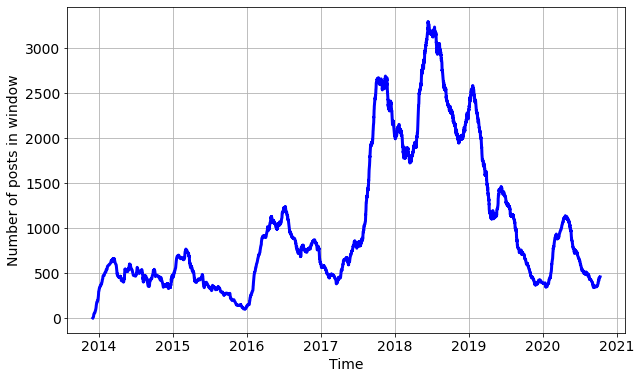

In [120]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(curr_posts["time"], rolling_post_counts.values, color="b", lw=3)
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Number of posts in window", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.grid()
plt.show()

In [121]:
fe_rolling = curr_posts.query('poster_id in @FE_users').rolling("90D", on="time", min_periods=20).count()["flag"]
re_rolling = curr_posts.query('poster_id in @RE_users').rolling("90D", on="time", min_periods=20).count()["flag"]

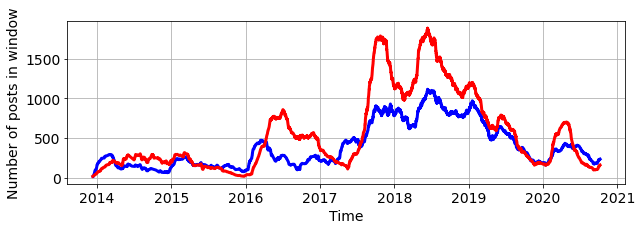

In [122]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(FE_user_posts["time"], fe_rolling.values, color="b", lw=3)
ax.plot(RE_user_posts["time"], re_rolling.values, color="r", lw=3)
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Number of posts in window", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.grid()
plt.show()

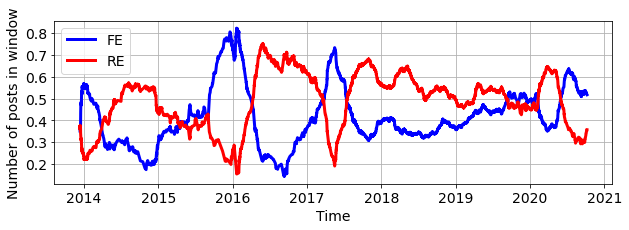

In [123]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(FE_user_posts["time"], (fe_rolling / rolling_post_counts.loc[fe_rolling.index]).values, color="b", lw=3, label="FE")
ax.plot(RE_user_posts["time"], (re_rolling / rolling_post_counts.loc[re_rolling.index]).values, color="r", lw=3, label="RE")
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Number of posts in window", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.legend(fontsize=14)
ax.grid()
plt.show()

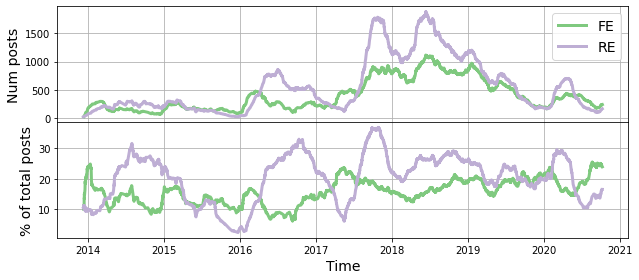

In [124]:
fe_posts.loc[:,"flag"] = [True] * len(fe_posts)
total_rolling = fe_posts.rolling("90D", on="time").count()["flag"]

colours = ["#7fc97f", "#beaed4"]

fig = plt.figure(figsize=(9, 4))
gs = fig.add_gridspec(2, hspace=0)
ax1, ax2 = gs.subplots(sharex=True)

ax1.plot(FE_user_posts["time"], fe_rolling.values, c=colours[0], lw=3, label="FE")
ax1.plot(RE_user_posts["time"], re_rolling.values, c=colours[1], lw=3, label="RE")

ax2.plot(FE_user_posts["time"], (fe_rolling / total_rolling.loc[fe_rolling.index]).values * 100, c=colours[0], lw=3)
ax2.plot(RE_user_posts["time"], (re_rolling / total_rolling.loc[re_rolling.index]).values * 100, c=colours[1], lw=3)

ax2.set_xlabel("Time", fontsize=14)
ax1.set_ylabel("Num posts", fontsize=14)
ax2.set_ylabel("% of total posts", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax1.legend(fontsize=14)
ax1.grid()
ax2.grid()
plt.tight_layout()
fig.savefig(os.path.join(GRAPH_DIR, "belief_posting_over_time.pdf"))
plt.show()

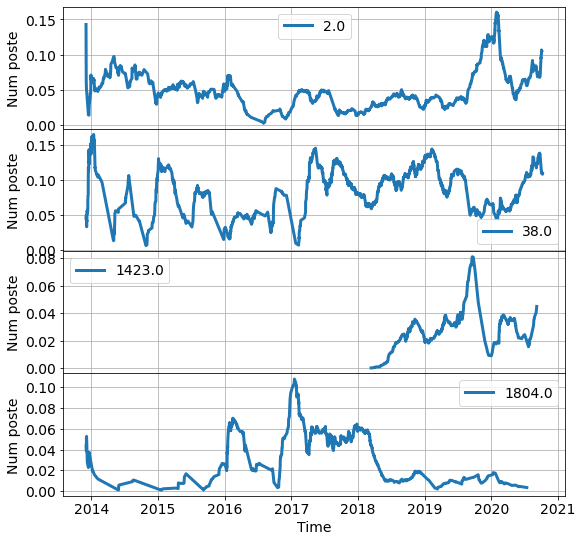

In [125]:
# fig, ax = plt.subplots(figsize=(10, 3))
fig = plt.figure(figsize=(9, 9))
gs = fig.add_gridspec(len(FE_users), hspace=0)
axes = gs.subplots(sharex=True)

for i, u in enumerate(FE_users):
    curr_u_posts = fe_posts.query("poster_id == @u")
    u_rolling = curr_u_posts.rolling("90D", on="time").count()["flag"]
    total_rolling = fe_posts.rolling("90D", on="time").count()["flag"]

#     axes[i].plot(curr_u_posts["time"], u_rolling.values, lw=3, label=u)
    axes[i].plot(curr_u_posts["time"], (u_rolling / total_rolling.loc[u_rolling.index]).values, lw=3, label=u)
    axes[i].set_ylabel("Num poste", fontsize=14)
    plt.setp(axes[i].get_yticklabels(), fontsize=14)
    axes[i].grid()
    axes[i].legend(fontsize=14)
    
# axes[i].legend(fontsize=14)
plt.setp(axes[-1].get_xticklabels(), fontsize=14)
axes[i].set_xlabel("Time", fontsize=14)
plt.show()

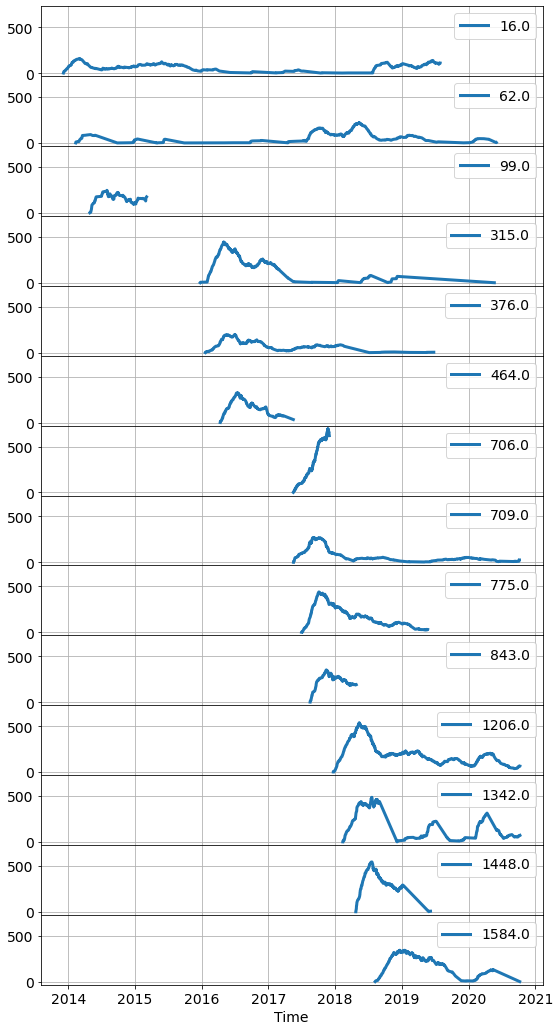

In [126]:
# fig, ax = plt.subplots(figsize=(10, 3))
fig = plt.figure(figsize=(9, 18))
gs = fig.add_gridspec(len(RE_users), hspace=0)
axes = gs.subplots(sharex=True, sharey=True)

for i, u in enumerate(RE_users):
    curr_u_posts = fe_posts.query("poster_id == @u")
    u_rolling = curr_u_posts.rolling("90D", on="time").count()["flag"]
    total_rolling = fe_posts.rolling("90D", on="time").count()["flag"]

    axes[i].plot(curr_u_posts["time"], u_rolling.values, lw=3, label=u)
#     axes[i].plot(curr_u_posts["time"], (u_rolling / total_rolling.loc[u_rolling.index]).values, lw=3, label=u)
#     axes[i].set_ylabel("Num poste", fontsize=14)
    plt.setp(axes[i].get_yticklabels(), fontsize=14)
    axes[i].grid()
    axes[i].legend(fontsize=14)
    
# axes[i].legend(fontsize=14)
plt.setp(axes[-1].get_xticklabels(), fontsize=14)
axes[i].set_xlabel("Time", fontsize=14)
plt.show()

In [127]:
get_cluster_keywords(user_toks, FE_belief.values)

FE
-------------------------------------------------------------------------------------
refrain             	      5.78	|	]                   	     -1.11
warned              	      5.53	|	(                   	     -1.11
fora                	      4.98	|	[                   	     -1.13
warning             	      4.04	|	x                   	     -1.15
basics              	      3.90	|	southern            	     -1.18
interactive         	      3.70	|	)                   	     -1.19
content             	      3.12	|	size                	     -1.23
moved               	      3.09	|	ground              	     -1.23
scene               	      2.94	|	measured            	     -1.29
traveling           	      2.82	|	angle               	     -1.30
upper               	      2.71	|	fake                	     -1.32
posting             	      2.54	|	bit                 	     -1.46
firmament           	      2.53	|	!                   	     -1.48
articles            	      2.41	|	height             

In [128]:
clust_lrs = get_cluster_lrs(user_toks, FE_belief.values)

In [129]:
clust_lrs["RE"]["flat"]

0.2343744600035263

In [130]:
clust_lrs["RE"]["globe"]

0.7259231234735904

In [131]:
c = "FE"
get_ngram_example(["fe'ers"],
                  user_toks[FE_belief==c],
                  doc_labels=user_toks[FE_belief==c].index, n_examples=25)

Showing 25 out of 103:
2.0        ts in which " theory " may be used by fe'ers . within the context of " conspiracy 
2.0        s used in exactly the same fashion by fe'ers as other scientists , by way of provi
2.0        y be correct if he simply spoke to no fe'ers at all . personally , i propose that 
2.0        t large . that is not a claim serious fe'ers would make , in my humble opinion . p
2.0        ct and following the more influential fe'ers online . in other words : yes , but y
2.0        hat the most - supported map is among fe'ers . could you just go away now ? how do
2.0        uld be silly . rowbotham 's and other fe'ers ' experiments are reproducible . rabi
2.0        ised for some of the more belligerent fe'ers which appeared to target him at the t
2.0        ace in the few . yes , there are some fe'ers who are working on alternative models
2.0        olly , we sure showed those gosh darn fe'ers ! " engaging with them is an utter wa
2.0        gestions have garnered cri

In [132]:
c = "RE"
get_ngram_example(["fe'ers"],
                  user_toks[FE_belief==c],
                  doc_labels=user_toks[FE_belief==c].index, n_examples=25)

Showing 25 out of 377:
16.0       ew earth , or one of the other fringe fe'ers . why ? we already have flat earth in
16.0       at , because that is an argument that fe'ers would lose . how 's this ? aether win
16.0       t will ever happen . unless and until fe'ers can start supporting their fe " model
16.0        than fes grade school . tom , to say fe'ers " often " try to provide supporting m
16.0       at i 've seen over the past 7 years , fe'ers tend to be deathly afraid of math . a
16.0       gulation . what i 'm talking about is fe'ers providing maths showing that fet does
16.0       ted to show why fet does n't work but fe'ers are n't obligated show why fet does w
16.0       s enough to empirically convince most fe'ers that the earth is flat . you take oth
16.0       ll see for yourself . actually , some fe'ers ( including the eminent samuel birley
16.0       just goes to show what slimy assholes fe'ers can be when they 're proven wrong . n
16.0        flat stationary earth . i

In [133]:
c = "FE"
get_ngram_example(["re'ers"],
                  user_toks[FE_belief==c],
                  doc_labels=user_toks[FE_belief==c].index, n_examples=25)

Showing 25 out of 131:
2.0        ! code : [ select ] to know that some re'ers do n't understand grade school physic
2.0        ers together with " to know that some re'ers do n't understand grade school physic
2.0         " , so i 'm not holding that against re'ers in general , but it does go a long wa
2.0         " unknown " and " untrue " ? because re'ers sure like to conflate the two when it
2.0        ld favourite of mine was to challenge re'ers to demonstrate that bananas attract e
2.0        ng bored with flogging a dead horse ( re'ers refusing to acknowledge our points an
2.0        forum . it 's just a circle - jerk of re'ers talking about how smart they think th
2.0        sadly you failed . since according to re'ers the cavendish experiment clearly work
2.0        u still here ? i have no problem with re'ers . i have a problem with people who co
2.0        very point of scepticism . unlike the re'ers who visit here to act all high and mi
2.0        oint ? no one makes that a

In [134]:
c = "RE"
get_ngram_example(["re'ers"],
                  user_toks[FE_belief==c],
                  doc_labels=user_toks[FE_belief==c].index, n_examples=25)

Showing 25 out of 64:
16.0       at you mention , the math was done by re'ers to show the improbability of the vari
16.0       aths showing that fet does work , not re'ers providing maths showing that fet does
16.0       ng to do with timing . why is it that re'ers are obligated to show why fet does n'
16.0       pp , you know that us poor , ignorant re'ers need to be spoon fed everything . tom
16.0        i 'm serious . there are a few of is re'ers ( well , me for one ) who would actua
16.0       and he has little use or patience for re'ers . if you 're an re'er , do n't even d
16.0        do n't think that very many people ( re'ers and fe'ers alike ) realize how much o
16.0       to answer a question that has plagued re'ers for many years : what evidence do re'
16.0       ers for many years : what evidence do re'ers need provide in order to satisfy thei
16.0       re seeing exactly the same thing that re'ers are seeing and the important parts of
16.0       rea where they can discuss 

In [135]:
c = "FE"
get_ngram_example(["flat", "earthers"],
                  user_toks[FE_belief==c],
                  doc_labels=user_toks[FE_belief==c].index, n_examples=25)

Showing 25 out of 81:
2.0        er well . unfortunately , not all flat earthers are zeteticists , and we do have 
2.0         comments from round earthers and flat earthers alike , i would like to ask every
2.0         answering questions on behalf of flat earthers , especially if you 're going to 
2.0        . a bunch of the things you say " flat earthers " claim simply do not apply to th
2.0        ng something along the lines of " flat earthers claim that 2+2=5 and that is wron
2.0        ere , welcome to the forum . most flat earthers are primarily concerned with the 
2.0        nestly do n't think there are any flat earthers here who would claim california a
2.0        up a relatively small minority of flat earthers , very far from your alleged " al
2.0        way to carry on doing his thing . flat earthers ( or fe'ers for short ) is the mo
2.0        adbible ( click ) 21/08/2017 what flat earthers are saying about the total solar 
2.0         global news ( click ) 30/10/2017 fla

In [136]:
c = "RE"
get_ngram_example(["flat", "earthers"],
                  user_toks[FE_belief==c],
                  doc_labels=user_toks[FE_belief==c].index, n_examples=25)

Showing 25 out of 263:
16.0       stances to be the same ? not even flat earthers ? then please do so . it would be
315.0      ht it was the south pole that the flat earthers claim does not exist , yet it is 
315.0      t all accept the " bible " of all flat earthers ! for myself , i find all this be
315.0      it might be understandable . many flat earthers ( including gotham in " the other
315.0       before , but it seems to me that flat earthers look out the window ( or out to s
315.0      the globe earth ! yet i have seen flat earthers ( maybe not you ) call newton an 
315.0      lot of the problem is that so few flat earthers take the trouble to find out how 
315.0      e gleason 's map is often used by flat earthers , it is not the " official map " 
315.0      t fit on a plane surface . we ask flat earthers to come with their measurements o
315.0      ioning the measurements , yet all flat earthers just ignore it ! [ 1 ] before the
315.0       needs a bit of magic sometimes . fl

In [137]:
c = "FE"
get_ngram_example(["round", "earthers"],
                  user_toks[FE_belief==c],
                  doc_labels=user_toks[FE_belief==c].index, n_examples=25)

Showing 25 out of 69:
2.0        l be helpful here : ( attention , round earthers : not to scale ) the mass of the 
2.0        r views . even the most laughable round earthers at least make an effort . you , o
2.0         round earth is much smaller than round earthers would have you believe . where cu
2.0        internet and are well accepted by round earthers . a quick google search to the ef
2.0        y our village idiot , jura . some round earthers are very upset by our site 's exi
2.0        bviously appreciate comments from round earthers and flat earthers alike , i would
2.0        ervation strikes me as accurate . round earthers have a strange sense of entitleme
2.0        ause of it . well , yeah , except round earthers claim that they 've already surve
2.0        al treatment . a certain group of round earthers , very notably including andruszk
2.0        , we have a small group of bitter round earthers who feel honour - bound to spit v
2.0        lain the stupid things some

In [138]:
c = "RE"
get_ngram_example(["round", "earthers"],
                  user_toks[FE_belief==c],
                  doc_labels=user_toks[FE_belief==c].index, n_examples=25)

Showing 25 out of 43:
315.0      r earth is round , so you are the round earthers . we are the globe earthers - i k
315.0       do you base your claim on that " round earthers " think " that disappearing from 
376.0      ng to win the debate . much as we round earthers here try to do . ( saying nothing
376.0      either as rowbotham says ( and we round earthers agree ) thicker air refracts ligh
376.0       , but nine of them are my fellow round earthers . it drew only one serious reply 
376.0      r offers objection to any one but round earthers ) and two other non-serious flat 
376.0      te usernames created by one of us round earthers . military folks like you and me 
376.0      having a laugh , the responses of round earthers like me would be the whole point 
376.0      ng it . this is good too , and we round earthers have often answered this without 
376.0      better and better ! are there any round earthers who still get to talk to intikam 
376.0      ght bends " . no worries , 

In [139]:
c = "RE"
get_ngram_example(["ghost"],
                  user_toks,
                  doc_labels=user_toks.index, n_examples=25)

Showing 25 out of 19:
2.0        cret user 7 markjo 6 saddam hussein 5 ghost spaghetti 3 rooster 3 squevil 2 beard
38.0        is similar to saying that there is a ghost in my house , but because i have n't 
38.0        " you know what , i 've never seen a ghost . i think that ghosts do n't exist . 
38.0       meet the burden . he has never seen a ghost . by default ghosts do not exist unti
38.0        of proof because he has never seen a ghost . the evidence to prove a negative is
38.0       st likely place to find evidence of a ghost from the person claiming that ghosts 
38.0       st likely place to find evidence of a ghost from the person claiming that ghosts 
38.0       s exactly the same as claiming that a ghost story was fabricated , or speculating
38.0       ating on what really happened in that ghost story . that position of skepticism i
38.0       epticism is not the positive claim in ghost debates . the positive claimant is th
38.0       ebates . the positive claimant is the

In [140]:
get_cluster_keywords(pos_trigrams, FE_belief.values)

FE
-------------------------------------------------------------------------------------
INTJ_VERB_ADP       	      2.41	|	PUNCT_PUNCT_ADV     	     -0.90
PROPN_ADV_DET       	      2.37	|	ADJ_PROPN_PUNCT     	     -0.91
ADJ_PROPN_PROPN     	      1.00	|	PUNCT_PUNCT_INTJ    	     -0.92
ADV_DET_PROPN       	      1.00	|	PUNCT_PUNCT_CCONJ   	     -0.92
NOUN_ADV_PART       	      0.98	|	PUNCT_NOUN_CCONJ    	     -0.95
PUNCT_INTJ_VERB     	      0.93	|	CCONJ_NUM_NOUN      	     -0.97
ADP_PROPN_ADV       	      0.92	|	CCONJ_ADP_DET       	     -0.98
PRON_NOUN_PART      	      0.88	|	NUM_PUNCT_PUNCT     	     -0.99
PROPN_PROPN_AUX     	      0.87	|	DET_PUNCT_NOUN      	     -1.02
PROPN_PROPN_NOUN    	      0.82	|	VERB_DET_PUNCT      	     -1.02
CCONJ_VERB_SCONJ    	      0.81	|	ADP_PUNCT_PROPN     	     -1.02
DET_PROPN_PROPN     	      0.81	|	ADV_NUM_NOUN        	     -1.03
INTJ_VERB_DET       	      0.81	|	NOUN_NUM_NOUN       	     -1.03
VERB_ADJ_PART       	      0.76	|	PUNCT_NUM_PUNCT    

In [141]:
c = "RE"
get_text_example_of_pos(["PROPN", "ADV", "DET"], 
                        user_pos[FE_belief==c], 
                        user_toks[FE_belief==c], 
                        doc_labels=user_toks[FE_belief==c].index, n_examples=25)

Showing 25 out of 116:
16.0       eminent samuel birley rowbotham of earth not a globe fame ) believe that the moon
16.0        is currently off the shore of antarctica where the magnetic field lines are verti
62.0       g new maps would be published ? is wgs84 just a nasa production ? yet there is no 
99.0        . so how is it you contradict rowbotham when this conclusion is " beyond the rea
99.0       h the illuminated face facing the sun when both are visible in the sky ) . d. moo
99.0        augment this thread and point f eers here every time one of them argues for a co
99.0       le to predict seeing less of the toronto when the winds are higher ? have you been
99.0        apparent retrograde motion of jupiter nearly every year . with such gaping holes 
99.0       ouraged ( wisely ) to chew through earth not a globe in morsels . i would encoura
99.0       h the illuminated face facing the sun when both are visible in the sky ) . d. moo
99.0       at you 're floating in the niaga

In [142]:
c = "RE"
get_text_example_of_pos(["NUM", "DET", "NOUN"], 
                        user_pos[FE_belief==c], 
                        user_toks[FE_belief==c], 
                        doc_labels=user_toks[FE_belief==c].index, n_examples=25)

Showing 25 out of 310:
16.0       ic location on the stage , not 1 / 2 the stage . if you have any doubts , remembe
16.0       ucation or human resources makes one an authority on the shape of the earth . then
62.0       in use . as he says when you dial 112 the phone uses any available network . noth
99.0       dle it . example : so for about $ 1000 any feer can prove fet false without any c
315.0       cape of good hope ( it is only about 34 a ̂ ° south ) then saying " there is a mi
315.0      ply : see a long winded article in . 720 a ̂° x ( area of the triangle ) / ( surfa
315.0       the equator to pole distance becomes 90 a ̂ ° x 60 ' x 1nm / min = 5,400 nm or 10
315.0      umference around the equator becomes 360 a ̂ ° x 60 ' x 1nm / min = 21,600 nm or 
315.0      8â°e our location at the station - 77.8 a ̂°n , 166.6 â° e declination at mcmurd
315.0       ( dip pole - vertical field ) is at 64.2 a ̂ ° s 136.4a ̂°e , not even within the
315.0      arke ross did not see it until